In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Load the data from Google Drive
file_path = r'C:\Projects\data_prac\Copy of Claims Minified Data.xlsx' 
df = pd.read_excel(file_path, sheet_name='Sheet4', engine='openpyxl')


print("Raw Data Shape:", df.shape)
print(df.head())
print(df.info())
print(df.describe())

Raw Data Shape: (1039, 42)
  REGISTRATION_DATE KC_REPUDIATE_DT  DRIVER_AGE  KC_OUTSTANDING_RESERVE  \
0       06-JAN-2025             NaN       -14.0                       0   
1       29-NOV-2024             NaN         0.0                     700   
2       21-MAR-2025             NaN         0.0                  120700   
3       13-DEC-2024             NaN         0.0                       0   
4       24-FEB-2025             NaN         0.0                   80200   

   TIME_TAKEN_REGISTRATION  KC_STATUS      KC_STATUS_TEXT POLICY_NUMBER##  \
0                        1         74  Authorized Payment     G/HQS/00001   
1                        1          2           INPROCESS     G/HQS/00002   
2                        1          5           INPROCESS     G/EMB/00003   
3                        1          2           INPROCESS     G/HGS/00004   
4                        1          5           INPROCESS     G/HGS/00004   

  CLAIMNUMBER## RISKNAME##  ... MANUFACTURING_YEAR POLICY_H

In [10]:
# Load the data (assuming the path is corrected as per previous advice)
file_path = r'C:\Projects\data_prac\Copy of Claims Minified Data.xlsx'  # Adjust to your local path
df = pd.read_excel(file_path, sheet_name='Sheet4', engine='openpyxl')

# Step 1: Handle column names (strip extras like '##')
df.columns = df.columns.str.strip().str.replace('##', '')

# Step 2: Handle missing values: Replace 'N/A', empty strings with NaN
df = df.replace(['N/A', ''], np.nan)

# Step 3: Parse dates (handle multiple formats)

date_cols = ['REGISTRATION_DATE', 'KC_REPUDIATE_DT', 'NOTIFICATE_DATE', 'DATE_LOSS',
             'NOTIFICATION_DATE', 'COVER_START_DATE', 'COVER_END_DATE']
for col in date_cols:
    df[col] = pd.to_datetime(df[col], errors='coerce', dayfirst=True, format='%d/%m/%Y')

# Step 4: Clean numerics: Convert to float/int, handle commas
numeric_cols = ['DRIVER_AGE', 'KC_OUTSTANDING_RESERVE', 'TIME_TAKEN_REGISTRATION',
                'KC_STATUS', 'KC_SUM_INSURED', 'MANUFACTURING_YEAR', 'POLICY_HOLDER_AGE']
for col in numeric_cols:
    df[col] = pd.to_numeric(df[col].astype(str).str.replace(',', ''), errors='coerce')

# Step 5: Handle age anomalies: Clip negative/zero ages to NaN or median

for age_col in ['DRIVER_AGE', 'POLICY_HOLDER_AGE']:
    df[age_col] = df[age_col].where(df[age_col] > 0, np.nan)
    median_age = df[age_col].median()
    df[age_col] = df[age_col].fillna(median_age)

# Step 6: Categoricals: Standardize case, strip extras
cat_cols = ['KC_STATUS_TEXT', 'POLICE_REPORTED', 'PERILNAME', 'IC_NAME', 'GP_NAME',
            'GCT_NAME', 'INT_TYP', 'BR_NAME', 'MAKE_NAME', 'MODEL_NAME',
            'POLICY_HOLDER_GENDER']
for col in cat_cols:
    df[col] = df[col].astype(str).str.strip().str.title()  # Title case for consistency
    df[col] = df[col].replace('Nan', pd.NA)

# Step 7: Drop duplicates if any (based on CLAIMNUMBER)
df = df.drop_duplicates(subset=['CLAIMNUMBER'])

# Step 8: Handle truncated text 
repud_cols = ['KC_FIRST_REPUDIATE_REM', 'KC_FIRST_REPUDIATE_REM_DATA',
              'KC_SECOND_REPUDIATE_REM', 'KC_FIFTH_REPUDIATE_REM']
df[repud_cols] = df[repud_cols].fillna('No Repudiation')


print("Cleaned Data Shape:", df.shape)
print(df.head())
print(df.info())
print(df.describe())

Cleaned Data Shape: (1039, 42)
  REGISTRATION_DATE KC_REPUDIATE_DT  DRIVER_AGE  KC_OUTSTANDING_RESERVE  \
0               NaT             NaT        31.0                       0   
1               NaT             NaT        31.0                     700   
2               NaT             NaT        31.0                  120700   
3               NaT             NaT        31.0                       0   
4               NaT             NaT        31.0                   80200   

   TIME_TAKEN_REGISTRATION  KC_STATUS      KC_STATUS_TEXT POLICY_NUMBER  \
0                        1         74  Authorized Payment   G/HQS/00001   
1                        1          2           Inprocess   G/HQS/00002   
2                        1          5           Inprocess   G/EMB/00003   
3                        1          2           Inprocess   G/HGS/00004   
4                        1          5           Inprocess   G/HGS/00004   

   CLAIMNUMBER RISKNAME  ... MANUFACTURING_YEAR POLICY_HOLDER_GENDE

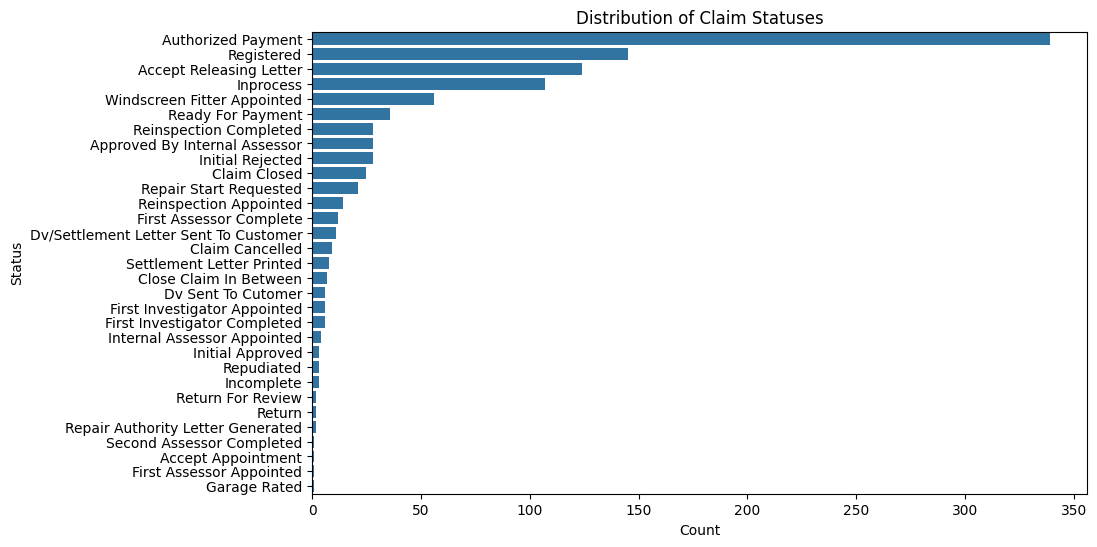

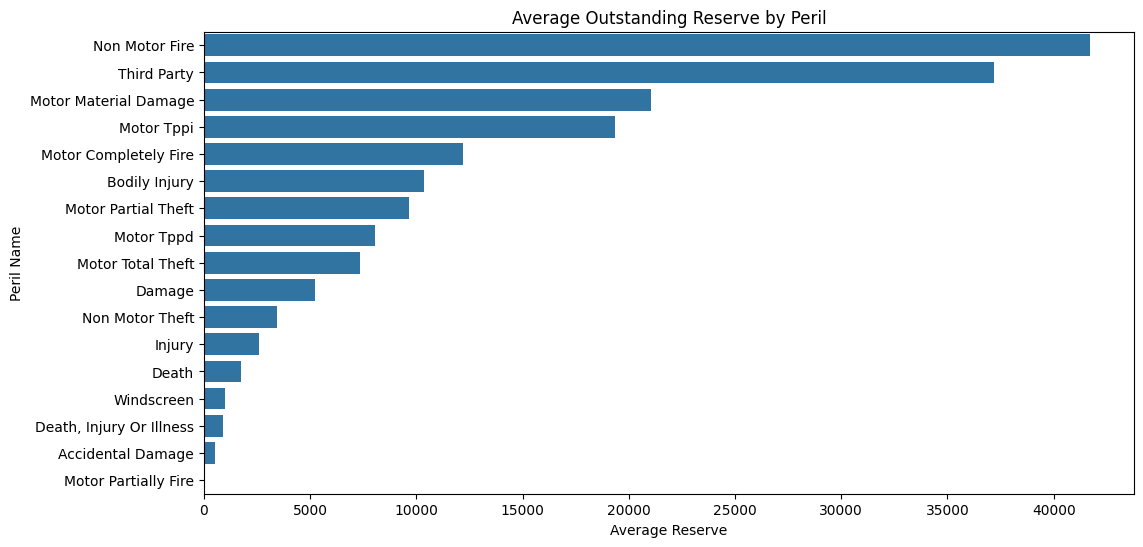

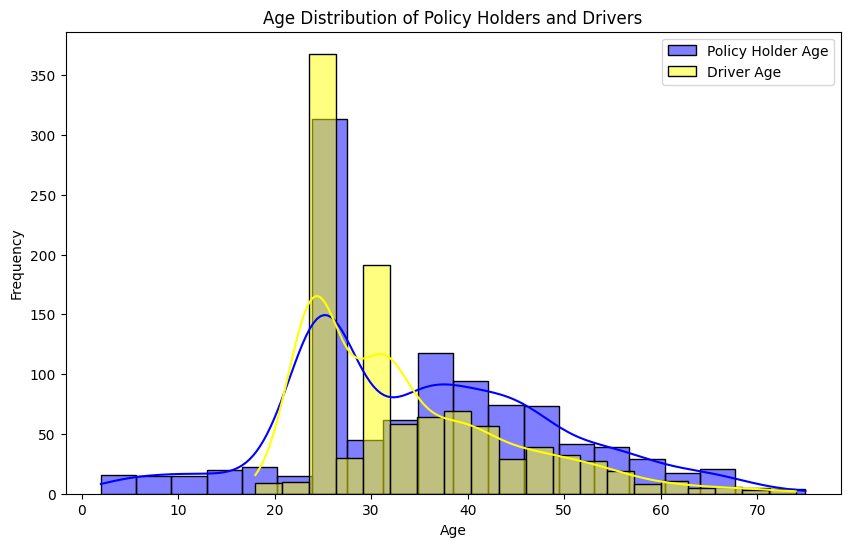

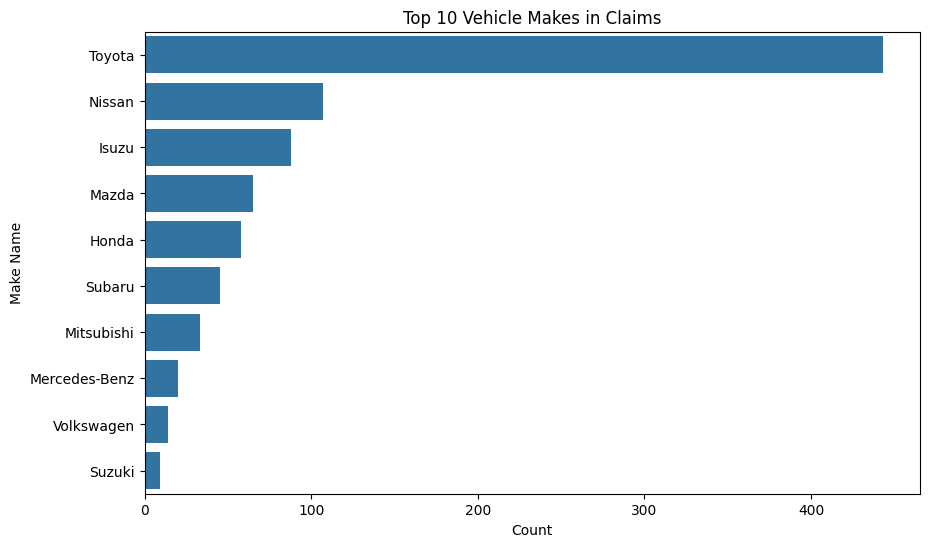

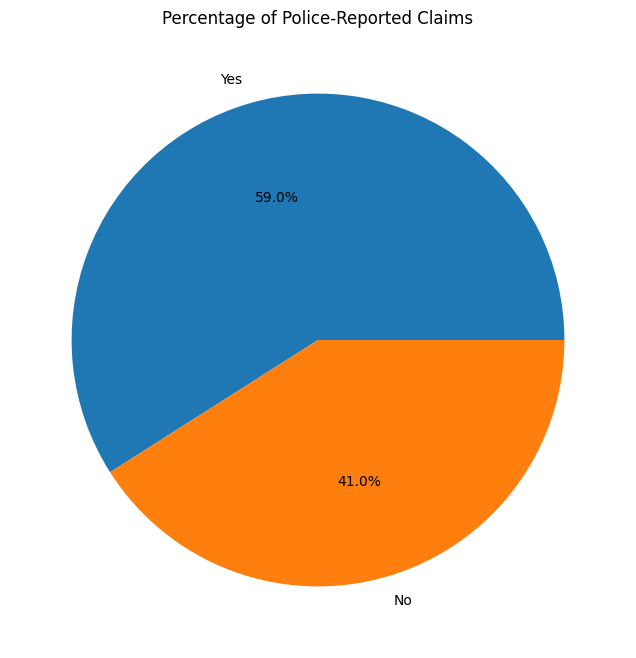

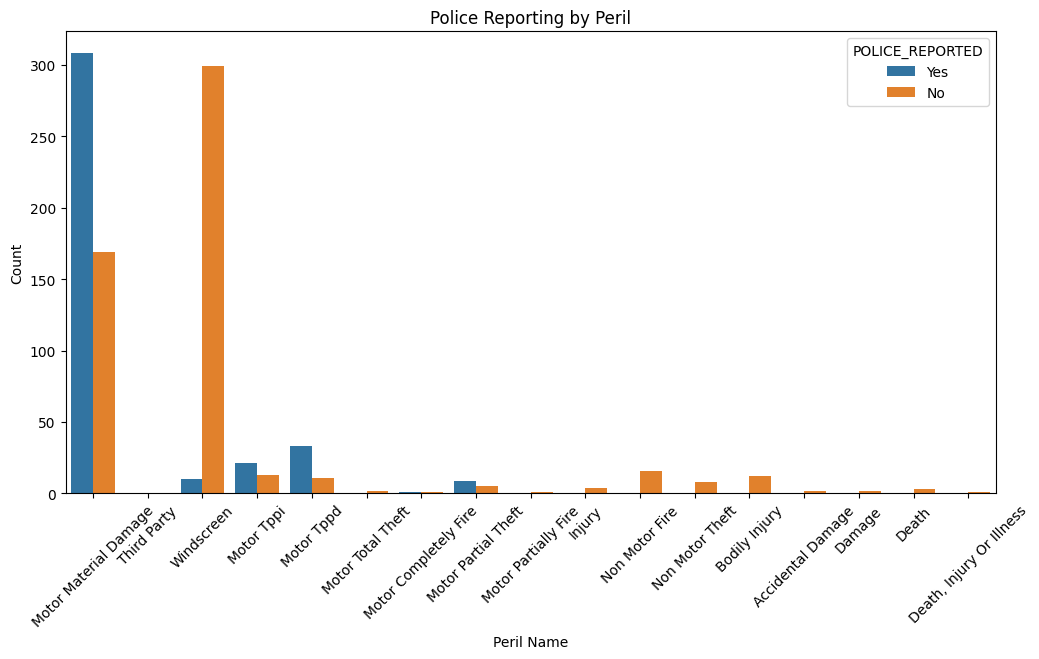

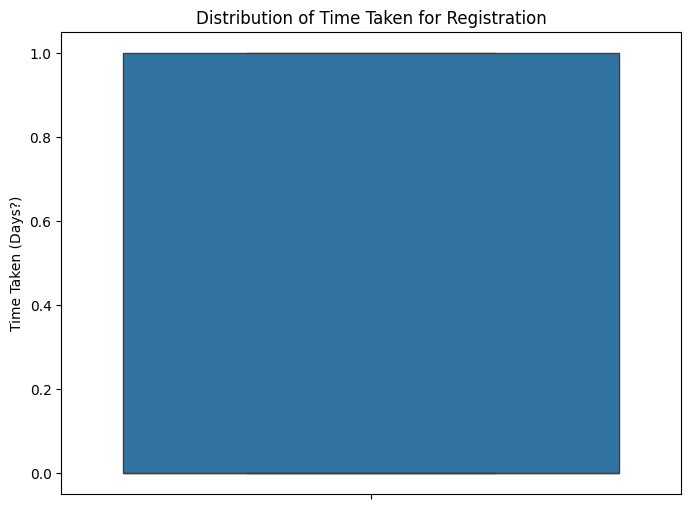

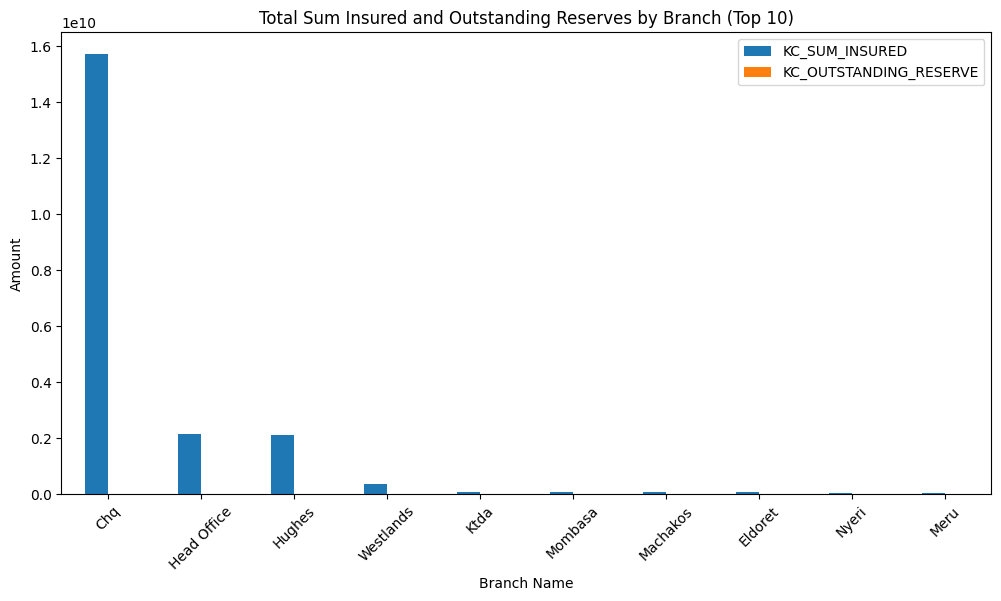

In [ ]:
# Viz 1: Claim Status Distribution (Bar Plot)
plt.figure(figsize=(10, 6))
sns.countplot(y='KC_STATUS_TEXT', data=df, order=df['KC_STATUS_TEXT'].value_counts().index)
plt.title('Distribution of Claim Statuses')
plt.xlabel('Count')
plt.ylabel('Status')
plt.show()

# Viz 2: Average Reserve by Peril (Bar Plot)
avg_reserve = df.groupby('PERILNAME')['KC_OUTSTANDING_RESERVE'].mean().sort_values(ascending=False).reset_index()
plt.figure(figsize=(12, 6))
sns.barplot(x='KC_OUTSTANDING_RESERVE', y='PERILNAME', data=avg_reserve)
plt.title('Average Outstanding Reserve by Peril')
plt.xlabel('Average Reserve')
plt.ylabel('Peril Name')
plt.show()

# Viz 3: Age Distribution (Histogram)
plt.figure(figsize=(10, 6))
sns.histplot(df['POLICY_HOLDER_AGE'], bins=20, kde=True, color='blue', label='Policy Holder Age')
sns.histplot(df['DRIVER_AGE'], bins=20, kde=True, color='red', label='Driver Age')
plt.title('Age Distribution of Policy Holders and Drivers')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# Viz 4: Top Vehicle Makes (Bar Plot)
top_makes = df['MAKE_NAME'].value_counts().head(10).reset_index(name='Count')
plt.figure(figsize=(10, 6))
sns.barplot(x='Count', y='MAKE_NAME', data=top_makes)
plt.title('Top 10 Vehicle Makes in Claims')
plt.xlabel('Count')
plt.ylabel('Make Name')
plt.show()

# Viz 5: Police Reporting Frequency (Pie Chart + Breakdown)
plt.figure(figsize=(8, 8))
df['POLICE_REPORTED'].value_counts().plot.pie(autopct='%1.1f%%', labels=['Yes', 'No', 'Other'])
plt.title('Percentage of Police-Reported Claims')
plt.ylabel('')
plt.show()

# Breakdown by Peril
plt.figure(figsize=(12, 6))
sns.countplot(x='PERILNAME', hue='POLICE_REPORTED', data=df)
plt.title('Police Reporting by Peril')
plt.xlabel('Peril Name')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

# Viz 7: Time Taken for Registration (Box Plot)
plt.figure(figsize=(8, 6))
sns.boxplot(y='TIME_TAKEN_REGISTRATION', data=df)
plt.title('Distribution of Time Taken for Registration')
plt.ylabel('Time Taken (Days?)')
plt.show()

# Viz 8: Sum Insured and Reserves by Branch (Grouped Bar Plot)
branch_stats = df.groupby('BR_NAME').agg({'KC_SUM_INSURED': 'sum', 'KC_OUTSTANDING_RESERVE': 'sum'}).reset_index().sort_values('KC_SUM_INSURED', ascending=False).head(10)
branch_stats.plot(x='BR_NAME', kind='bar', figsize=(12, 6))
plt.title('Total Sum Insured and Outstanding Reserves by Branch (Top 10)')
plt.xlabel('Branch Name')
plt.ylabel('Amount')
plt.xticks(rotation=45)
plt.show()

In [8]:
# saving a cleaned version 
df.to_csv('C:/Projects/data_prac/cleaned_claims_data.csv', index=False)
